# PyVista for OpenFOAM

Manipulation and visualization of OpenFOAM results using PyVista: see [here](https://docs.pyvista.org/examples/99-advanced/openfoam_example.html) for more details.

We will analyse a flow over cylinder problem solved with OpenFOAM-com (v2012). Remember to unzip the `flowcyl.zip` file in the same directory as this notebook.

Read the OpenFOAM case from a `.foam` file

In [5]:
import pyvista as pv

reader = pv.POpenFOAMReader('flowcyl/foam.foam')

The case contains an `UnstructuredGrid` element containing the fields `U`, `p`. The default time step is `0`, but you can change it to any other time step available in the case.

In [6]:
reader.read()

MultiBlock (0x16b76aaa0)
  N Blocks    2
  X Bounds    -0.608, 1.120
  Y Bounds    -0.600, 0.600
  Z Bounds    -0.007, 0.007

The time instants saved can be printed

In [ ]:
times = reader.time_values

[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0]

## Contour plotting
In `internalMesh`, the fields are saved as point data or cell data, which can be used for plotting.

In [21]:
reader.set_active_time_value(reader.time_values[-1])
mesh = reader.read()['internalMesh']
mesh

UnstructuredGrid (0x302cf7580)
  N Cells:    34764
  N Points:   70396
  X Bounds:   -6.075e-01, 1.120e+00
  Y Bounds:   -6.000e-01, 6.000e-01
  Z Bounds:   -7.500e-03, 7.500e-03
  N Arrays:   4

Let us make a subplot: let us take a slice being this a 2D problem

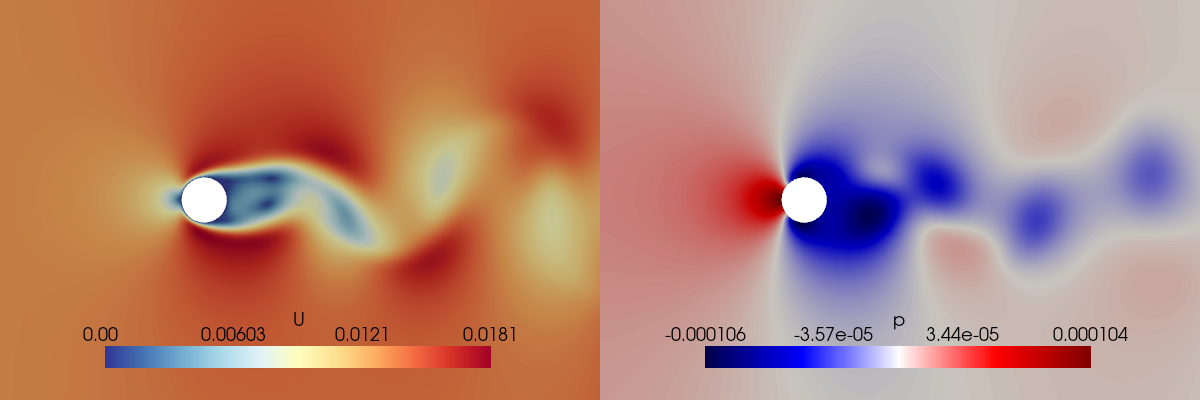

In [51]:
dict_cb = dict( width = 0.65, height = 0.15,
                    n_labels=4,
                    color = 'k',
                    position_x=0.175, position_y=0.0785,
                    shadow=False) 


pl = pv.Plotter(shape=(1, 2), border=False, window_size=(1200, 400))

pl.subplot(0,0)
pl.add_mesh(mesh.slice(normal='z'), scalars='U', cmap='RdYlBu_r', scalar_bar_args=dict_cb)

pl.subplot(0,1)
pl.add_mesh(mesh.slice(normal='z'), scalars='p', cmap='seismic', scalar_bar_args=dict_cb)

for i in range(2):
    pl.subplot(0, i)
    pl.view_xy()
    pl.camera.zoom(2)

pl.show(jupyter_backend='static')

## Data Manipulation
We can also calculate the vorticity field $\boldsymbol{\omega} = \nabla \times \mathbf{u}$, which is a vector field, using the `vorticity` filter.

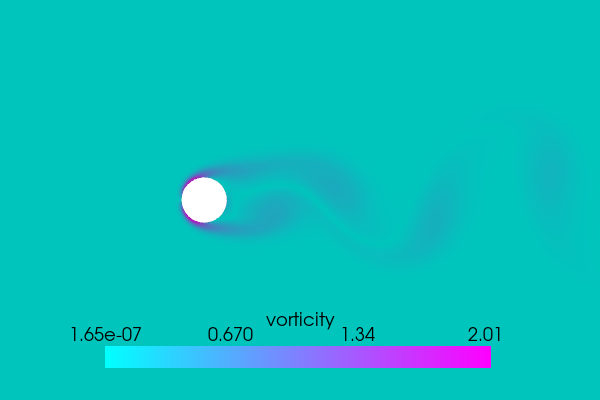

In [87]:
mesh['vorticity'] = mesh.compute_derivative(scalars='U', vorticity=True)['vorticity']

pl = pv.Plotter(window_size=(600, 400))
pl.add_mesh(mesh.slice(normal='z'), scalars='vorticity', cmap='cool', scalar_bar_args=dict_cb)

pl.view_xy()
pl.camera.zoom(2)

pl.show(jupyter_backend='static')

Also, derivates like gradient and divergence can be calculated. For example, the gradient of the pressure field $p$ is a vector field $\nabla p$.

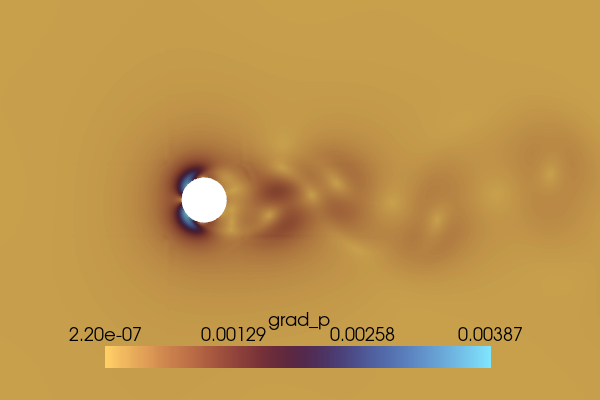

In [88]:
mesh['grad_p'] = mesh.compute_derivative(scalars='p', gradient=True)['gradient']

pl = pv.Plotter(window_size=(600, 400))
pl.add_mesh(mesh.slice(normal='z'), scalars='grad_p', cmap='managua', scalar_bar_args=dict_cb)
pl.view_xy()
pl.camera.zoom(2)

pl.show(jupyter_backend='static')

Let us also calculate the divergence of the velocity field $\nabla \cdot \mathbf{u}$, which is a scalar field: since the flow is incompressible, this should be reasonably close to zero.

In [84]:
mesh.compute_derivative(scalars='U', divergence=True)['divergence'].mean()

6.4915384e-06

Let us calculate the Q-criterion. Starting from the tensor of the velocity field:

$$
S = \frac{1}{2}\left(\nabla \mathbf{u} + (\nabla \mathbf{u})^T\right)
\quad\text{e}\quad
\Omega = \frac{1}{2}\left(\nabla \mathbf{u} - (\nabla \mathbf{u})^T\right)
$$

the formulation of the Q-criterion is:

$$ 
Q = \frac{1}{2}\left(\|\Omega\|^2 - \|S\|^2\right)
$$

where $\|\cdot\|$ is the Frobenius norm.

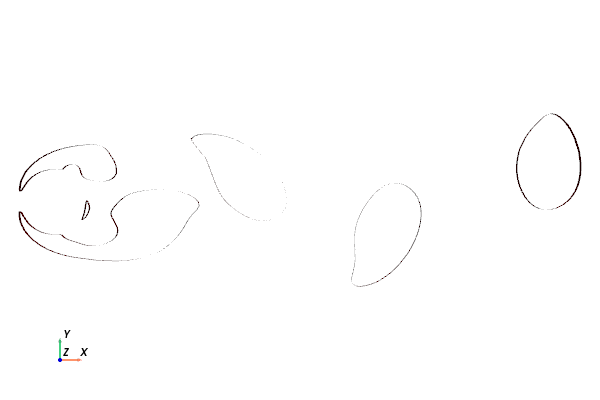

In [128]:
import numpy as np

mesh['criterion_q'] = mesh.compute_derivative(scalars='U', qcriterion=True)['qcriterion']

q_thres = np.percentile(mesh['criterion_q'], 95)

pl = pv.Plotter(window_size=(600, 400))
pl.add_mesh(mesh.contour(isosurfaces=[q_thres], scalars='criterion_q'), scalars='criterion_q', cmap='jet_r', show_scalar_bar=False)
pl.add_axes()

pl.view_xy()
pl.camera.zoom(1.5)   

pl.show(jupyter_backend='static')

## Integral Calculations

`PyVista` can also calculate integrals over the mesh. For example, we can calculate the integral of the pressure field on the whole domain.

In [126]:
print('U:         ', mesh.integrate_data()['U'][0])
print('p:         ', mesh.integrate_data()['p'][0])
print('vorticity: ', mesh.integrate_data()['vorticity'][0])

U:          [ 4.03745810e-04 -1.07005666e-06  1.26237701e-24]
p:          7.345072318449489e-09
vorticity:  [ 1.63994584e-21  3.73016912e-21 -3.76893031e-05]
